In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import plot
from tqdm.notebook import tqdm

In [3]:
# convert a corr_metrics row to a list
def row_to_list(row):
    return row.tolist()
# apply the function to each row of the dataframe

In [ ]:
# load csv file 
corr_metrics = pd.read_csv('exploratory/corr_metrics_10min_03-10.csv')
spread_metrics = pd.read_csv('exploratory/spead_metrics.csv')

In [ ]:
spead_metrics_list = spread_metrics.apply(row_to_list, axis=1)

In [ ]:
meanSpread = spead_metrics_list[1][6:]
# plot the mean and absolute average correlation metrics
plt.figure(figsize=(12, 6))
plt.plot(meanSpread, label='Spread', marker='o')
# show a vertical line at 30 min
plt.axvline(x=3, color='red', linestyle='--', label='30 min mark')
plt.title('Spread over time')
plt.xlabel('Time Bucket (10 min)')
plt.ylabel('Spread Value')
plt.xticks(ticks=np.arange(len(meanSpread)), labels=[f'{i*10}-{(i+1)*10}' for i in range(len(meanSpread))])
plt.legend()
plt.grid()

In [ ]:
corr_metrics_list = corr_metrics.apply(row_to_list, axis=1)

In [ ]:
mean = corr_metrics_list[1][6:]
abs_avg = corr_metrics_list[4][6:]
# plot the mean and absolute average correlation metrics
plt.figure(figsize=(12, 6))
plt.plot(mean, label='Mean Correlation', marker='o')
plt.plot(abs_avg, label='Absolute Average Correlation', marker='x')
# show a vertical line at 30 min
plt.axvline(x=3, color='red', linestyle='--', label='30 min mark')
plt.title('Mean and Absolute Average Correlation Metrics')
plt.xlabel('Time Bucket (10 min)')
plt.ylabel('Correlation Value')
plt.xticks(ticks=np.arange(len(mean)), labels=[f'{i*10}-{(i+1)*10}' for i in range(len(mean))])
plt.legend()
plt.grid()


## Beta Calculations

In [5]:
# read csv file
sanity_check = pd.read_csv('sanity_check_data.csv')

In [6]:
nifty_returns = sanity_check['normalized_returns_UNDERLYING_NIFTY']
es_returns = sanity_check['normalized_returns_UNDERLYING_ESMINI']
timestamp = pd.to_datetime(sanity_check['SCHEDULED_TS'])

# create a dataframe for these 3 columns
returnsDF = pd.DataFrame({
    'timestamp': timestamp,
    'nifty_returns': nifty_returns,
    'es_returns': es_returns
})

In [7]:
def rolling_beta(nifty_returns, es_returns, window):
    betas = []
    for i in range(window, len(nifty_returns)):
        X = es_returns[i-window:i].values.reshape(-1, 1)
        y = nifty_returns[i-window:i].values
        model = LinearRegression().fit(X, y)
        betas.append(model.coef_[0])
    return pd.Series([np.nan]*window + betas, index=nifty_returns.index)

In [8]:
def add_rolling_beta(df, window):
    """
    Given a DataFrame with columns 'nifty_returns' and 'es_returns',
    compute the rolling beta (regression slope of nifty on ES) over
    the past `window` rows, and append it as 'rolling_beta'.
    """
    betas = [np.nan] * len(df)
    model = LinearRegression()
    
    for i in range(window, len(df)):
        X = df['es_returns'].iloc[i-window:i].values.reshape(-1, 1)
        y = df['nifty_returns'].iloc[i-window:i].values
        betas[i] = model.fit(X, y).coef_[0]
    
    df = df.copy()
    df['rolling_beta'] = betas
    return df

In [16]:
temp = returnsDF.copy()

In [20]:
# Loop with progress bar
for i in tqdm(range(1, 15), desc="Calculating Rolling Betas"):
    temp[f'rolling_beta_{i}'] = rolling_beta(temp['nifty_returns'], temp['es_returns'], window=i*10)

Calculating Rolling Betas:   0%|          | 0/14 [00:00<?, ?it/s]

In [21]:
temp

,timestamp,nifty_returns,es_returns,rolling_beta_1,rolling_beta_2,rolling_beta_3,rolling_beta_4,rolling_beta_5,rolling_beta_6,rolling_beta_7,rolling_beta_8,rolling_beta_9,rolling_beta_10,rolling_beta_11,rolling_beta_12,rolling_beta_13,rolling_beta_14
0,2023-01-03 04:45:00+00:00,0.003032,0.000033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-03 04:49:00+00:00,0.002959,-0.000054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-03 04:50:00+00:00,0.002930,-0.000218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-03 04:51:00+00:00,0.003270,-0.000510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-03 04:58:00+00:00,0.003020,-0.000637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108516,2024-12-31 09:41:00+00:00,0.000371,0.001028,0.073741,-0.447663,-0.557522,-0.484378,-0.578848,-0.577115,-0.564043,-0.543163,-0.514150,-0.493145,0.333481,0.651845,0.640484,0.637361
108517,2024-12-31 09:42:00+00:00,0.000859,0.001028,0.082731,-0.461548,-0.565108,-0.480817,-0.576593,-0.577398,-0.567838,-0.559483,-0.513383,-0.493449,0.146296,0.659324,0.638324,0.638625
108518,2024-12-31 09:52:00+00:00,0.000232,0.001422,0.089298,-0.523910,-0.528500,-0.481933,-0.577845,-0.576577,-0.565596,-0.569525,-0.501506,-0.491393,-0.467273,0.645559,0.637759,0.640535
108519,2024-12-31 09:53:00+00:00,0.000115,0.001089,0.036717,-0.526690,-0.444887,-0.477703,-0.569360,-0.579829,-0.564442,-0.562336,-0.489388,-0.501833,-0.472381,0.621379,0.636045,0.640649


In [ ]:
rollingbeta_fig = go.Figure()
for i in range(1, 15):
    rollingbeta_fig.add_trace(
        go.Scatter(
            x=temp['timestamp'],
            y=temp[f'rolling_beta_{i}'],
            mode='lines',
            name=f'Rolling Beta (Window {i*10})'
        )
    )

rollingbeta_fig.update_layout(
    title='Rolling Betas Across Window Sizes',
    xaxis_title='Timestamp',
    yaxis_title='Beta Coefficient',
    width=1200,
    height=600
)

# Opens the interactive plot in your default web browser
plot(rollingbeta_fig, auto_open=True)


'temp-plot.html'

In [22]:
temp['expected_nifty_returns'] = temp['rolling_beta_14'] * temp['es_returns']
temp['spread'] = temp['nifty_returns'] - temp['expected_nifty_returns']

In [23]:
# drop any Nan values from any column
dropped_temp = temp.dropna()

In [26]:
dropped_temp.to_csv('dropped_temp.csv')

In [14]:
dropped_temp.set_index('timestamp', inplace=True)
dropped_temp.index = pd.to_datetime(dropped_temp.index)
dropped_temp = dropped_temp.dropna()

## Bucket the Data

## Train and use different models

In [ ]:
%load_ext autoreload	
%autoreload 2	
from boosting import TrainTestXGBoost	

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Confusion Matrix:
 [[29592  1516]
 [ 9746  2499]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.95      0.84     31108
           1       0.62      0.20      0.31     12245

    accuracy                           0.74     43353
   macro avg       0.69      0.58      0.57     43353
weighted avg       0.72      0.74      0.69     43353



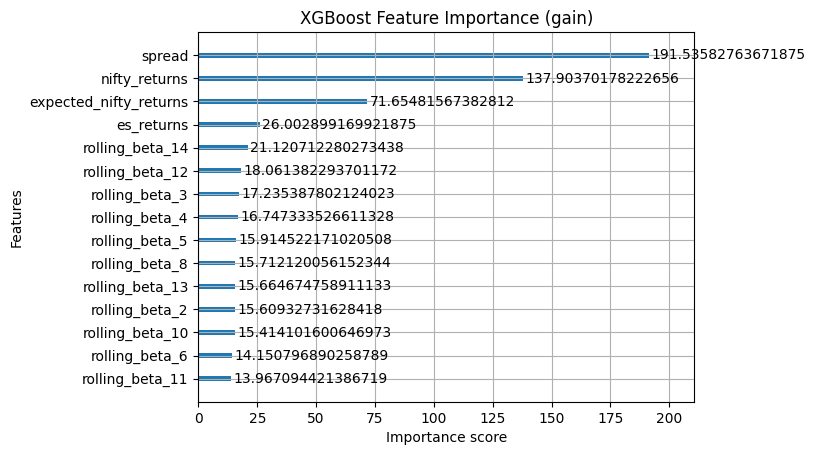

In [ ]:

# df must already contain:
#   nifty_returns, es_returns, spread, expected_nifty_returns,
#   rolling_beta_1 … rolling_beta_n
model = TrainTestXGBoost(label_horizon=10, test_size=0.4, shuffle=False)

# train
model.fit(dropped_temp)

# evaluate on hold-out
model.evaluate()

# optional: visualise which betas and features matter most
model.plot_feature_importance()


In [ ]:
y_proba = model.model.predict_proba(model.X_test_)[:, 1]

# hard 0 / 1 prediction (threshold = 0.5 by default)
y_pred  = model.model.predict(model.X_test_)

# the actual labels you held out — created in model.fit()
y_true  = model.y_test_

model.X_test_.index = pd.to_datetime(model.X_test_.index)

# 2  Build an aligned DataFrame
results_df = pd.DataFrame({
    "timestamp": model.X_test_.index,   # ← guaranteed same length
    "predicted_label": y_pred,
    "predicted_proba": y_proba,
    "actual_label": y_true.values,
}).sort_values("timestamp")

results_df

,timestamp,predicted_label,predicted_proba,actual_label
0,2024-02-16 09:37:00+00:00,0,0.250446,0
1,2024-02-16 09:38:00+00:00,0,0.276333,0
2,2024-02-16 09:39:00+00:00,0,0.208291,0
3,2024-02-16 09:40:00+00:00,0,0.272424,0
4,2024-02-16 09:41:00+00:00,0,0.304548,0
...,...,...,...,...
43348,2024-12-31 09:41:00+00:00,1,0.776106,0
43349,2024-12-31 09:42:00+00:00,0,0.212637,0
43350,2024-12-31 09:52:00+00:00,1,0.747789,0
43351,2024-12-31 09:53:00+00:00,1,0.742154,0


In [28]:
time_index = dropped_temp.set_index('timestamp')

In [29]:
time_index

,nifty_returns,es_returns,rolling_beta_1,rolling_beta_2,rolling_beta_3,rolling_beta_4,rolling_beta_5,rolling_beta_6,rolling_beta_7,rolling_beta_8,rolling_beta_9,rolling_beta_10,rolling_beta_11,rolling_beta_12,rolling_beta_13,rolling_beta_14,expected_nifty_returns,spread
timestamp,,,,,,,,,,,,,,,,,,
2023-01-03 07:49:00+00:00,0.000311,0.000911,-0.088928,0.216095,0.089254,0.158558,0.494158,0.550022,0.548878,0.545097,0.480198,0.509727,0.492763,0.486969,0.466042,0.326691,0.000298,0.000013
2023-01-03 07:50:00+00:00,0.000400,0.000632,0.071133,0.123482,0.097544,0.154207,0.482368,0.552493,0.553568,0.549684,0.486417,0.511435,0.501839,0.488003,0.478482,0.333658,0.000211,0.000189
2023-01-03 07:51:00+00:00,0.000239,0.001007,-0.001048,0.098929,0.111739,0.196561,0.470203,0.557256,0.556778,0.554777,0.493262,0.514779,0.508356,0.488954,0.483947,0.343612,0.000346,-0.000107
2023-01-03 07:52:00+00:00,0.000333,0.001007,0.079336,0.109104,0.120118,0.213590,0.433606,0.560805,0.559530,0.560021,0.500430,0.510074,0.517794,0.488568,0.488183,0.358050,0.000361,-0.000027
2023-01-03 07:53:00+00:00,0.000187,0.001076,0.076449,0.125302,0.126501,0.242389,0.429827,0.566394,0.563482,0.564877,0.518185,0.505781,0.525717,0.490082,0.493290,0.385615,0.000415,-0.000228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 09:41:00+00:00,0.000371,0.001028,0.073741,-0.447663,-0.557522,-0.484378,-0.578848,-0.577115,-0.564043,-0.543163,-0.514150,-0.493145,0.333481,0.651845,0.640484,0.637361,0.000655,-0.000285
2024-12-31 09:42:00+00:00,0.000859,0.001028,0.082731,-0.461548,-0.565108,-0.480817,-0.576593,-0.577398,-0.567838,-0.559483,-0.513383,-0.493449,0.146296,0.659324,0.638324,0.638625,0.000657,0.000203
2024-12-31 09:52:00+00:00,0.000232,0.001422,0.089298,-0.523910,-0.528500,-0.481933,-0.577845,-0.576577,-0.565596,-0.569525,-0.501506,-0.491393,-0.467273,0.645559,0.637759,0.640535,0.000911,-0.000679
